In [1]:
import numpy as np
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#生成数据集
max_degree=20
n_train,n_test=100,100
true_w=np.zeros(max_degree)
true_w[0:4]=np.array([5,1.2,-3.4,5.6])

features=np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i]/=math.gamma(i+1)  # gamma(n)=(n-1)!
labels=np.dot(poly_features,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape)  #scale参数表示标准差

In [3]:
#转化为tensor张量
true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]
features[:2],poly_features[:2,:],labels[:2]

(tensor([[-0.2848],
         [-0.0083]]),
 tensor([[ 1.0000e+00, -2.8478e-01,  4.0551e-02, -3.8494e-03,  2.7406e-04,
          -1.5610e-05,  7.4091e-07, -3.0143e-08,  1.0730e-09, -3.3953e-11,
           9.6693e-13, -2.5033e-14,  5.9409e-16, -1.3014e-17,  2.6474e-19,
          -5.0262e-21,  8.9461e-23, -1.4987e-24,  2.3711e-26, -3.5539e-28],
         [ 1.0000e+00, -8.3007e-03,  3.4451e-05, -9.5322e-08,  1.9781e-10,
          -3.2839e-13,  4.5432e-16, -5.3873e-19,  5.5898e-22, -5.1555e-25,
           4.2794e-28, -3.2293e-31,  2.2338e-34, -1.4263e-37,  8.4567e-41,
          -4.6243e-44,  0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00]]),
 tensor([4.4997, 4.8899]))

In [4]:
def evaluate_loss(net,data_iter,loss):
    metric=d2l.Accumulator(2)
    for X,y in data_iter:
        out=net(X)
        y=y.reshape(out.shape)
        l=loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

In [5]:
def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
    loss=nn.MSELoss()
    input_shape=train_features.shape[-1]
    net=nn.Sequential(nn.Linear(input_shape,1,bias=False))
    batch_size=min(10,train_labels.shape[0])
    trainer=torch.optim.SGD(net.parameters(),lr=0.01)
    train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size,is_train=True)
    test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)
    animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',
                         xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch==0 or (epoch+1)%20==0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),
                                 evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())

weight: [[ 4.992626   1.2033625 -3.3874915  5.602083 ]]


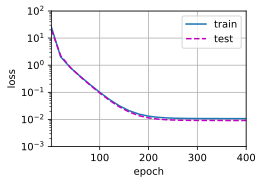

In [6]:
#用三阶多项式拟合
train(poly_features[:n_train,0:4],poly_features[n_train:,0:4],labels[:n_train],labels[n_train:])

weight: [[2.9819148 3.7941167]]


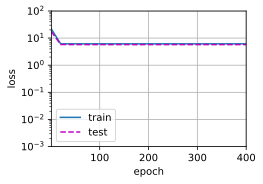

In [7]:
train(poly_features[:n_train,0:2],poly_features[n_train:,0:2],labels[:n_train],labels[n_train:])

weight: [[ 4.9568443   1.2512503  -3.2058148   5.234177   -0.5698815   1.4685886
  -0.1073556  -0.01156141 -0.07210251  0.19818076  0.02977357  0.06485156
  -0.15416582  0.14523515 -0.21366352 -0.14491627  0.11017929 -0.17423478
   0.14604229  0.02685094]]


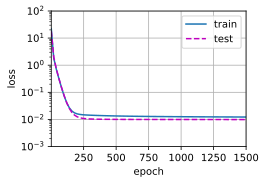

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)